In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from dataloader import DataLoader
from PIL import Image
from _graphutils import GraphUtils
from _plotutils import PlotUtils
from kernels.wlkernel import WLKernel
from kernels.shortestpathkernel import ShortestPathKernel
from kernels.randomwalkkernel import RandomWalkKernel
from kernels.labelhasher import LabelHasher
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import LeaveOneOut
from scipy.stats import linregress
from collections import defaultdict


In [3]:
dl = DataLoader("../eyelink_data")
imgs = dl.get_annotated_images()

PLOT = {
    "aois": False,
    "scanpaths": False,
    "clustering": False,
    "matrices": False,
    "graphs": False,
    "kernel": False,
    "tsne": False,
    "mds": True,
    "loocv": False
}

In [5]:
M = np.array([
    [2, 3, 5],
    [1, 4, 0],
    [0, 0, 0]
])
M

array([[2, 3, 5],
       [1, 4, 0],
       [0, 0, 0]])

/home/simontitk/projects/python/gaze3p/src/_graphutils.py:107: RuntimeWarning: invalid value encountered in divide
  transition_matrix_norm = transition_matrix / rows_sum[:, np.newaxis]
/tmp/ipykernel_23462/3121550740.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 1, figsize=(11, 8))


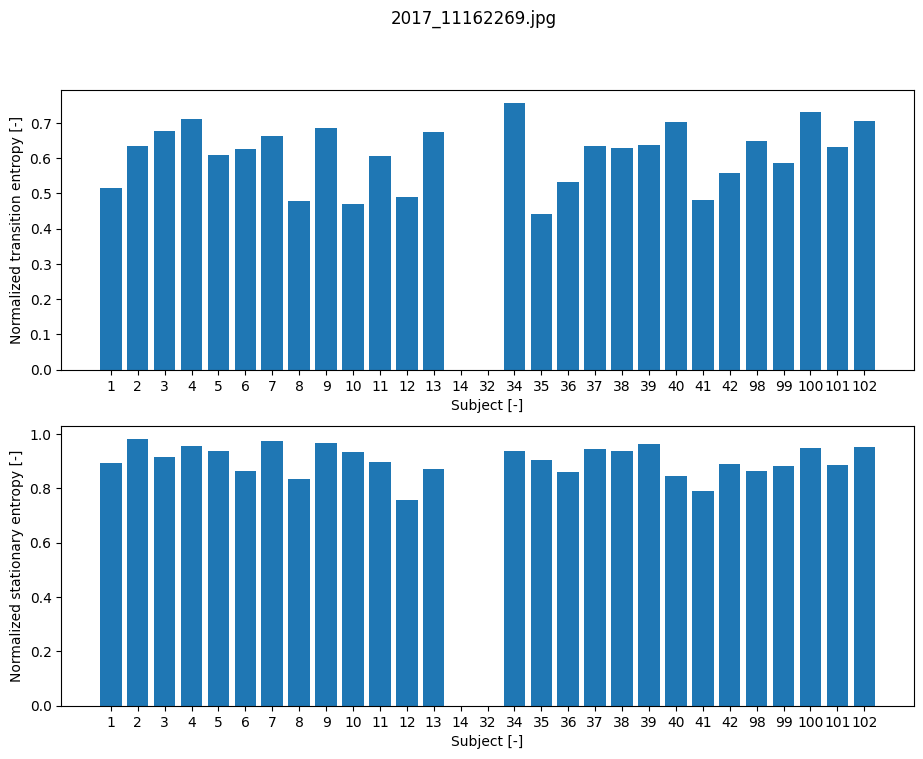

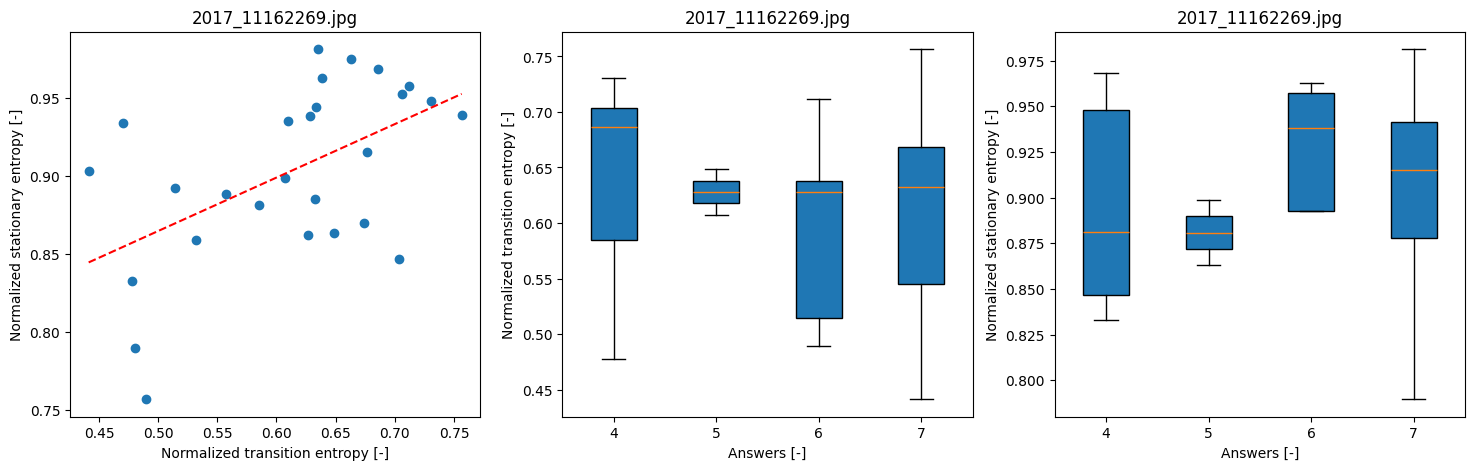

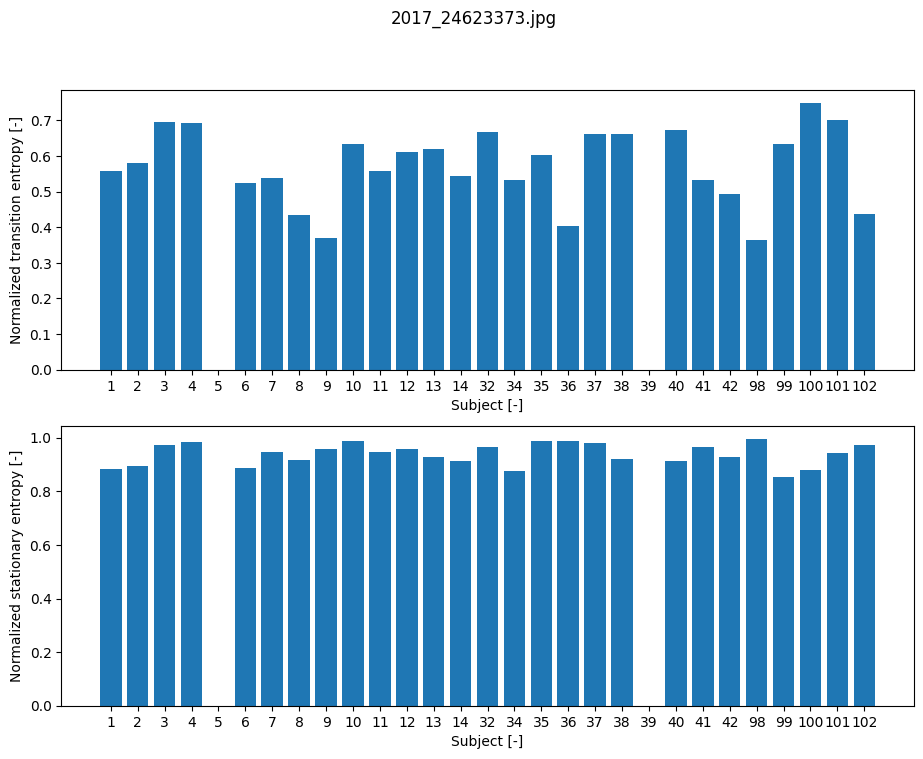

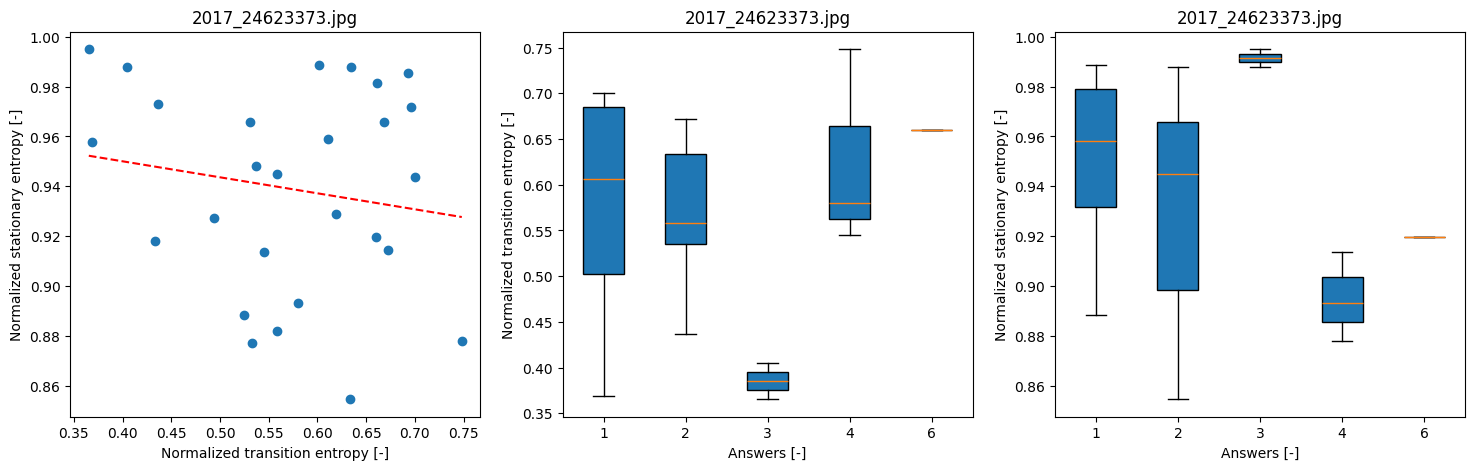

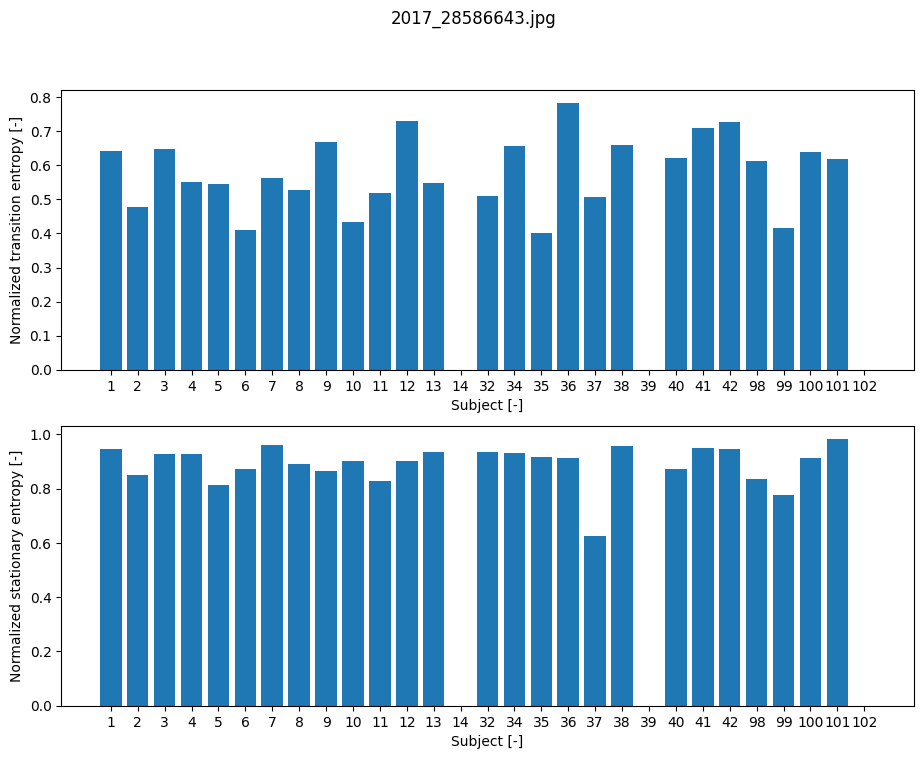

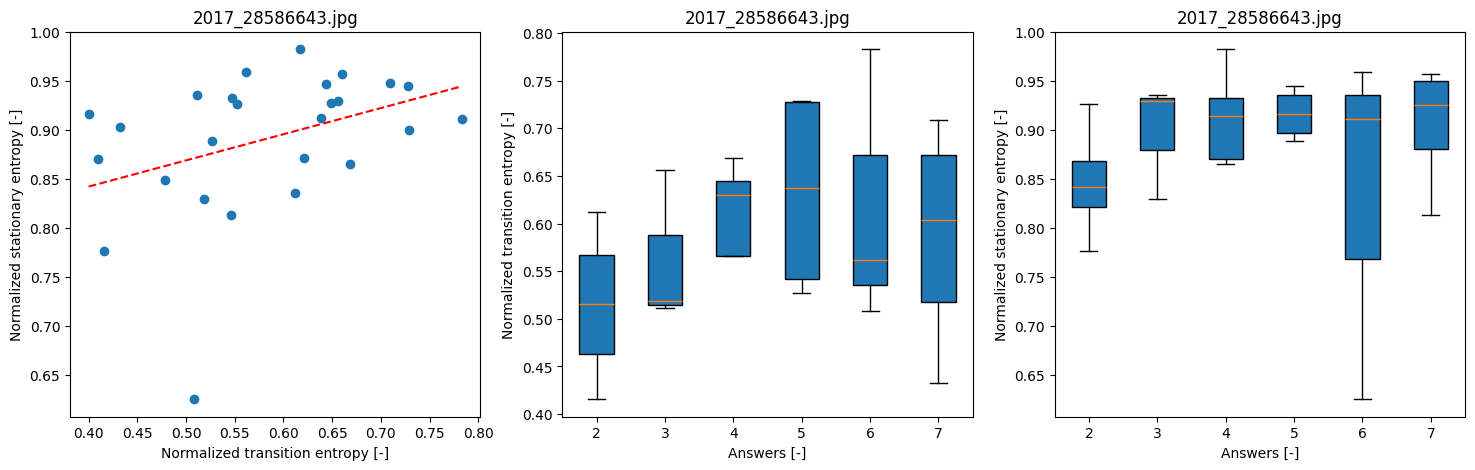

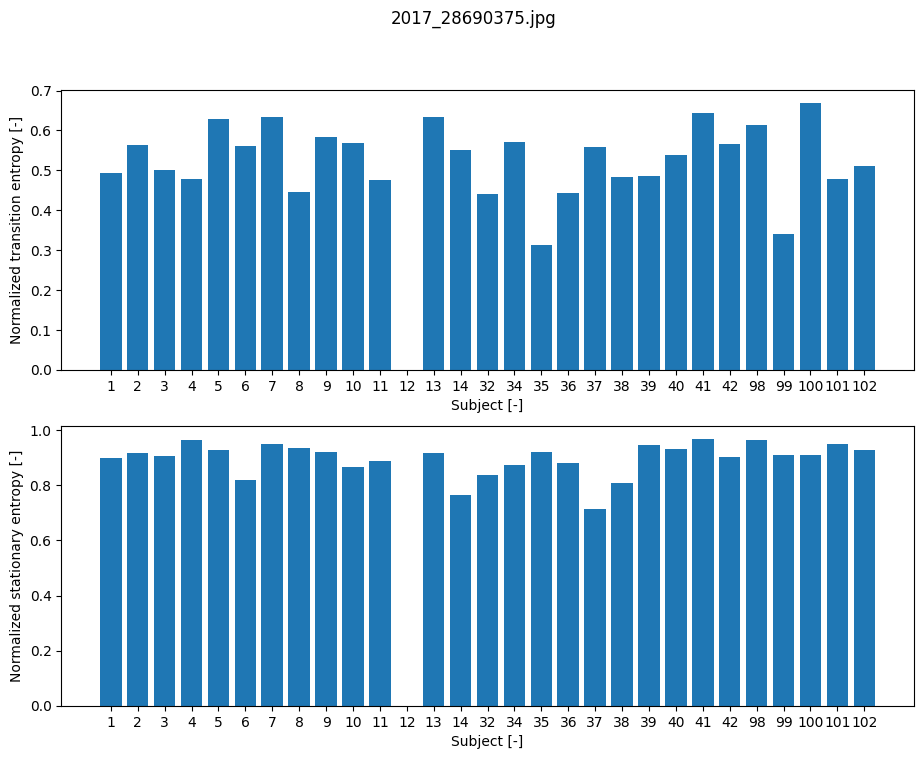

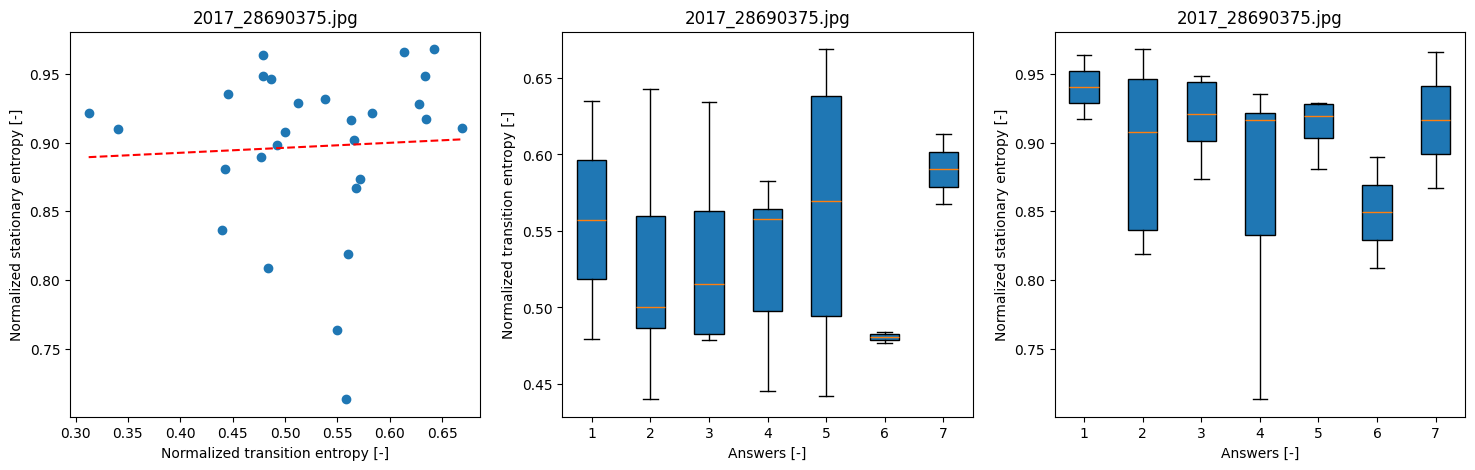

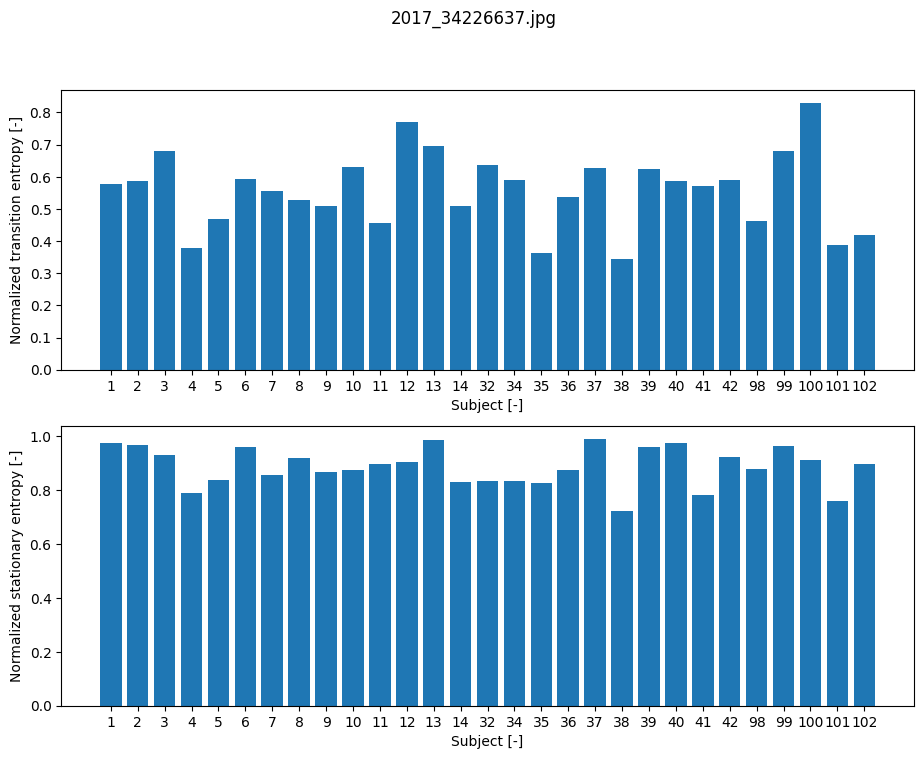

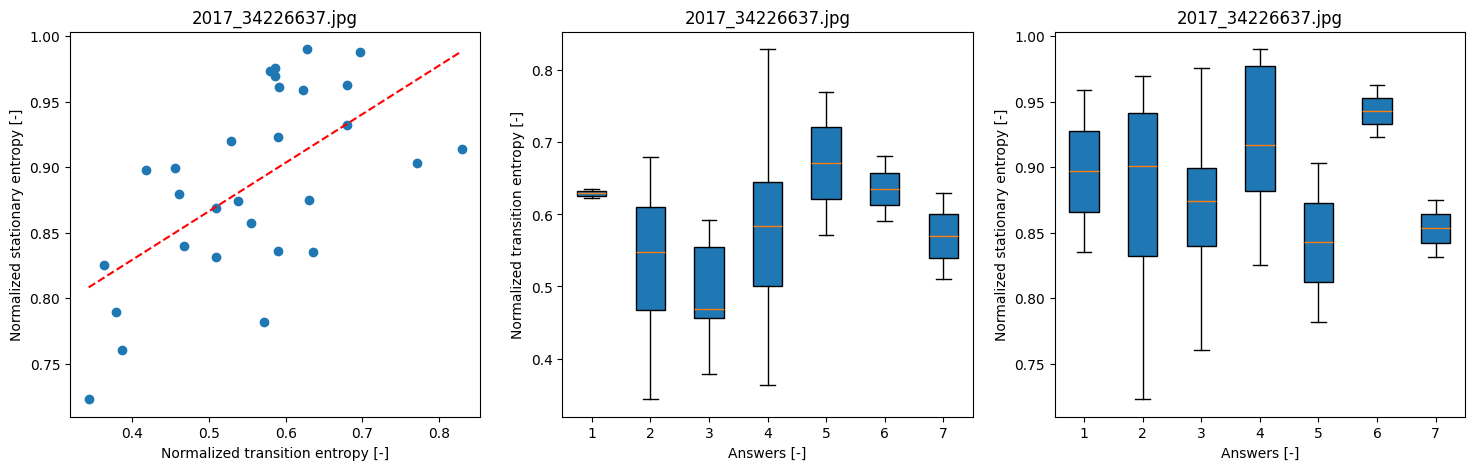

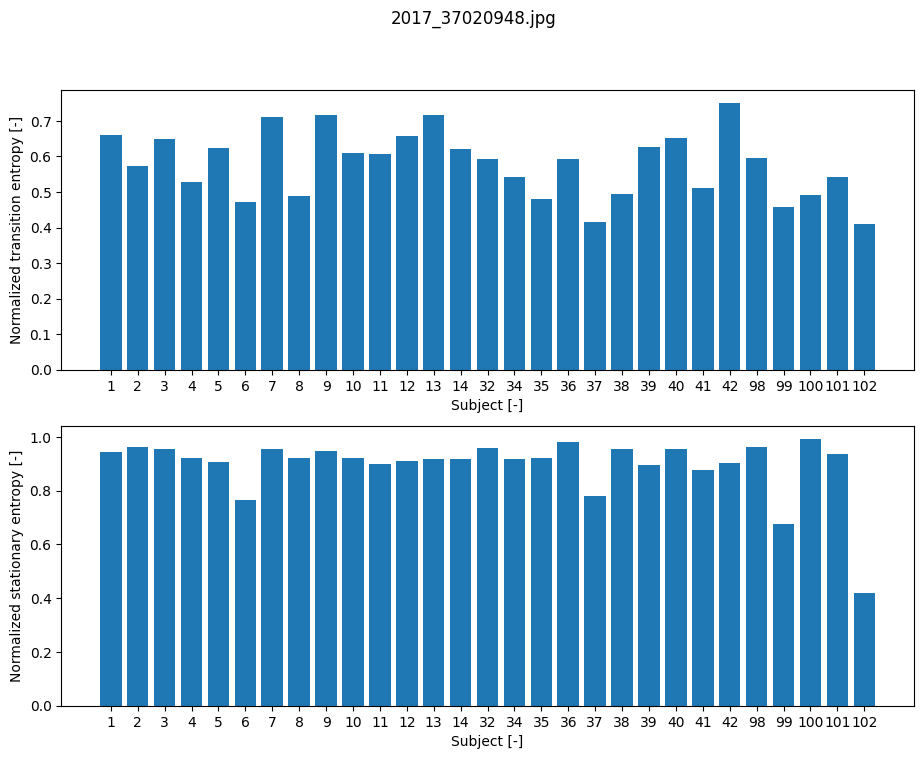

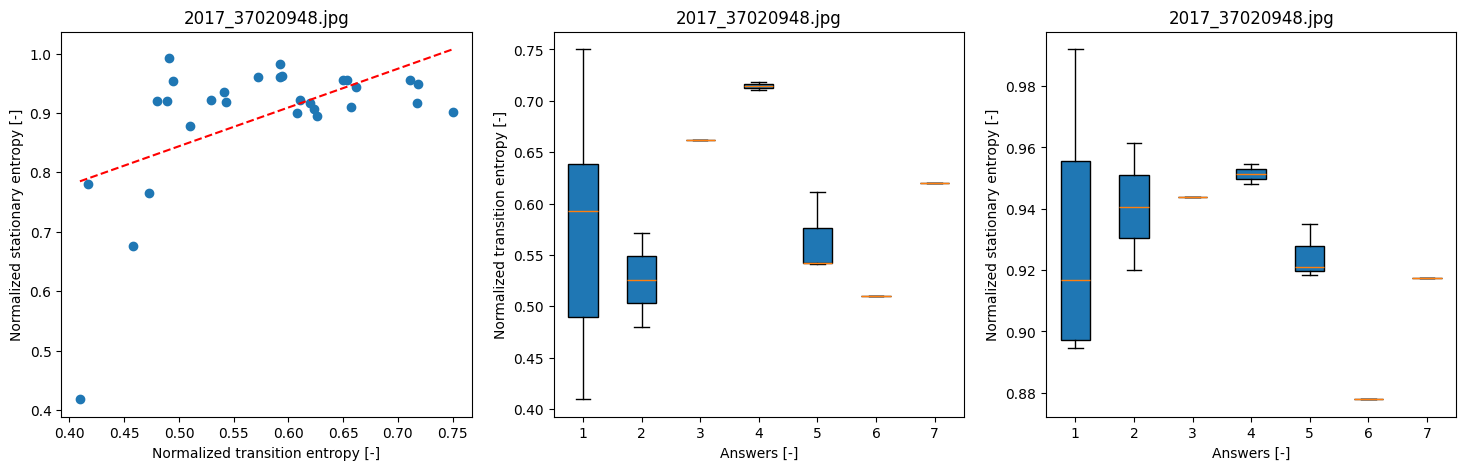

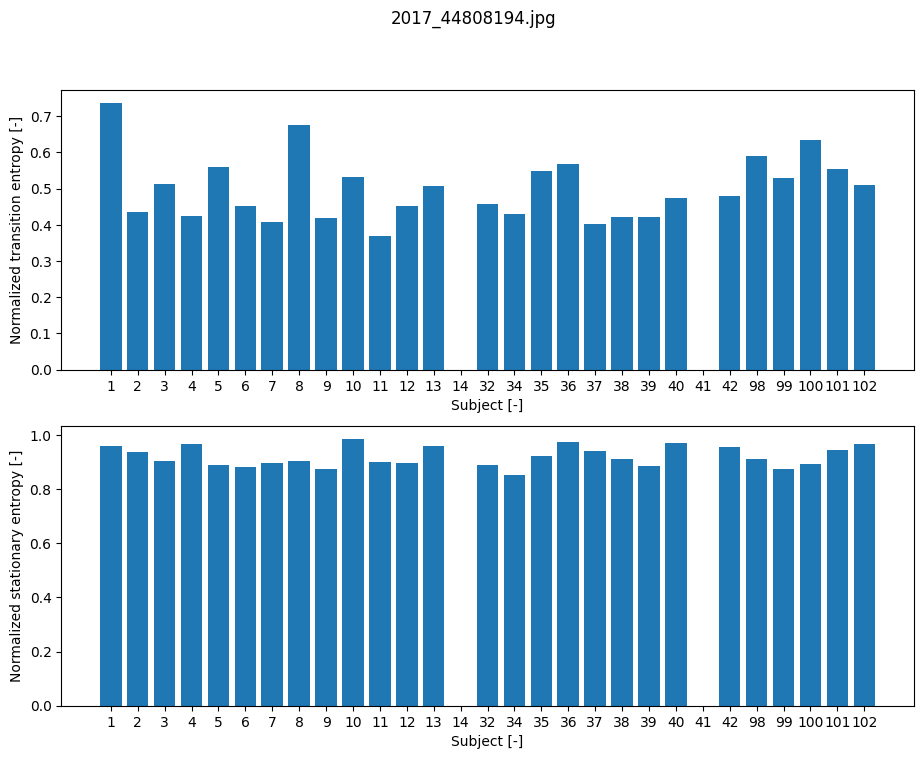

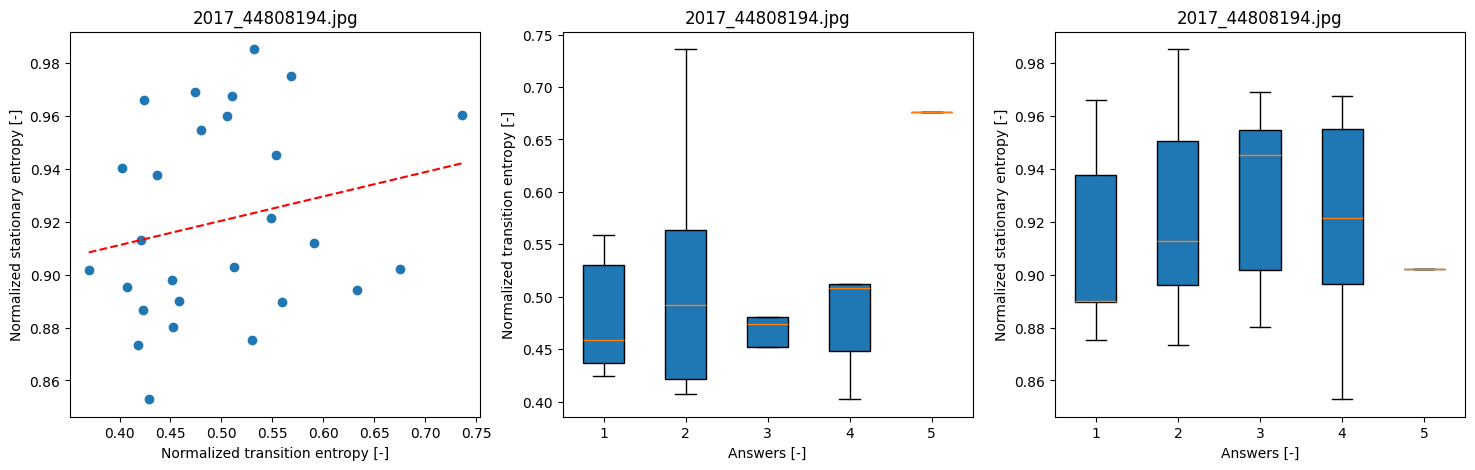

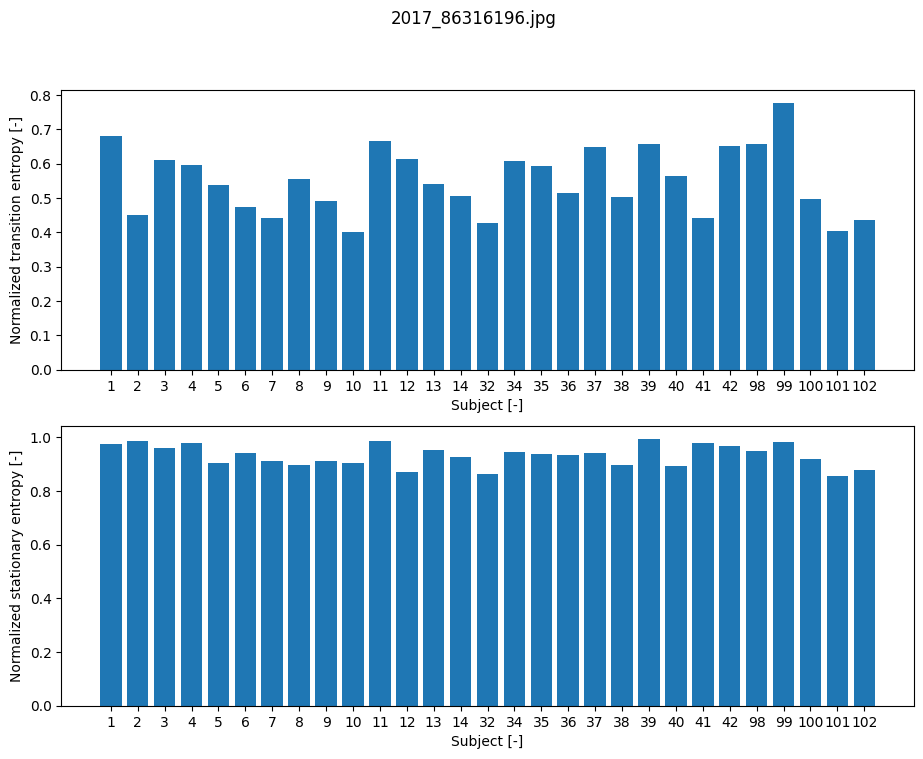

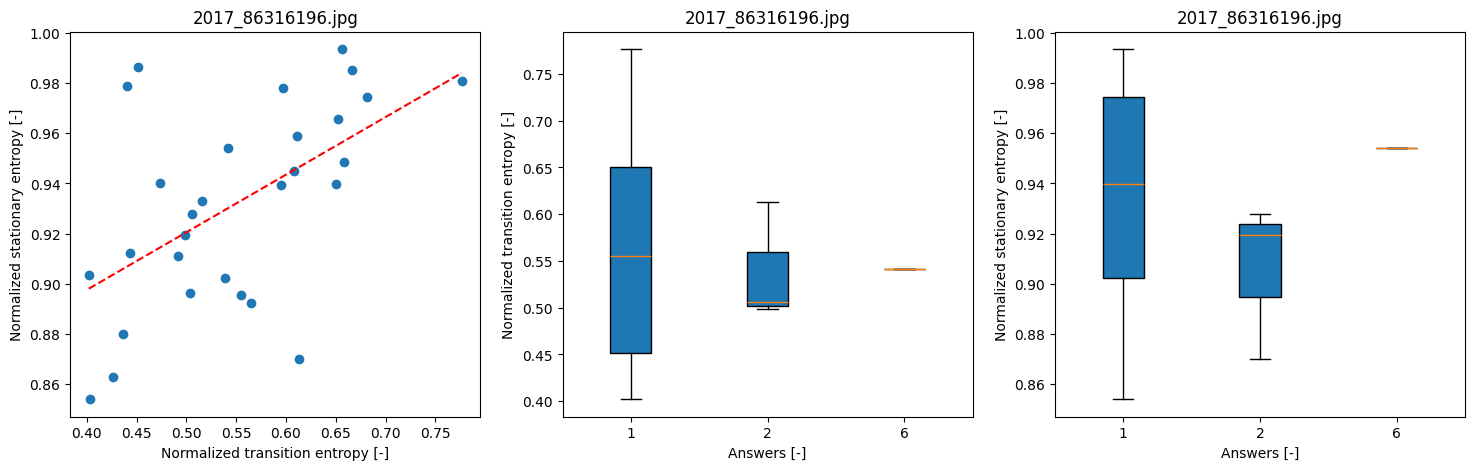

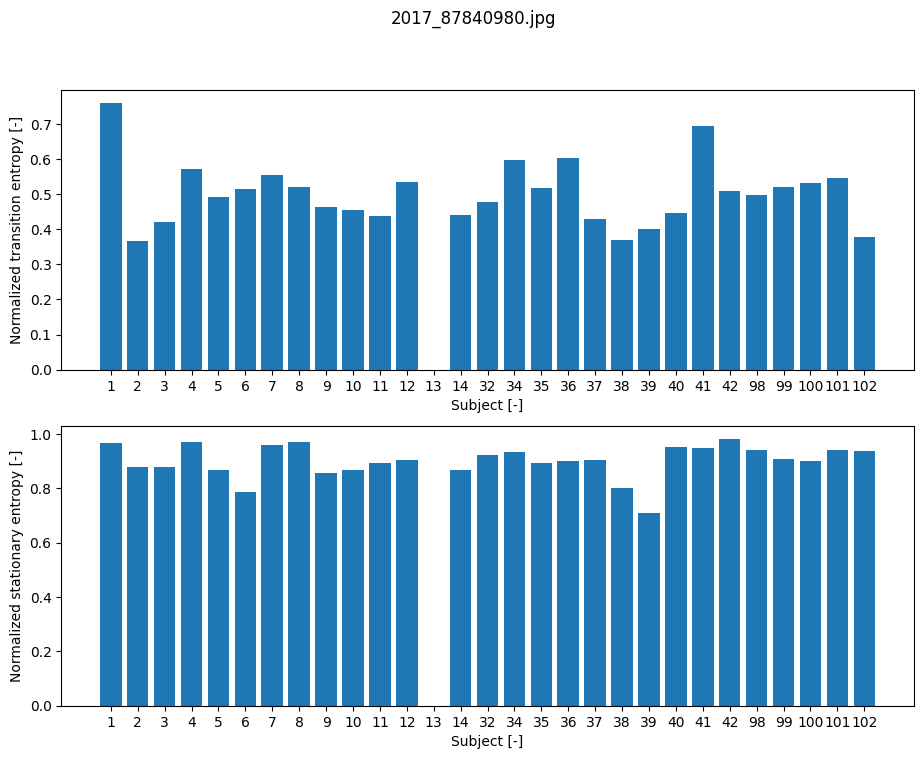

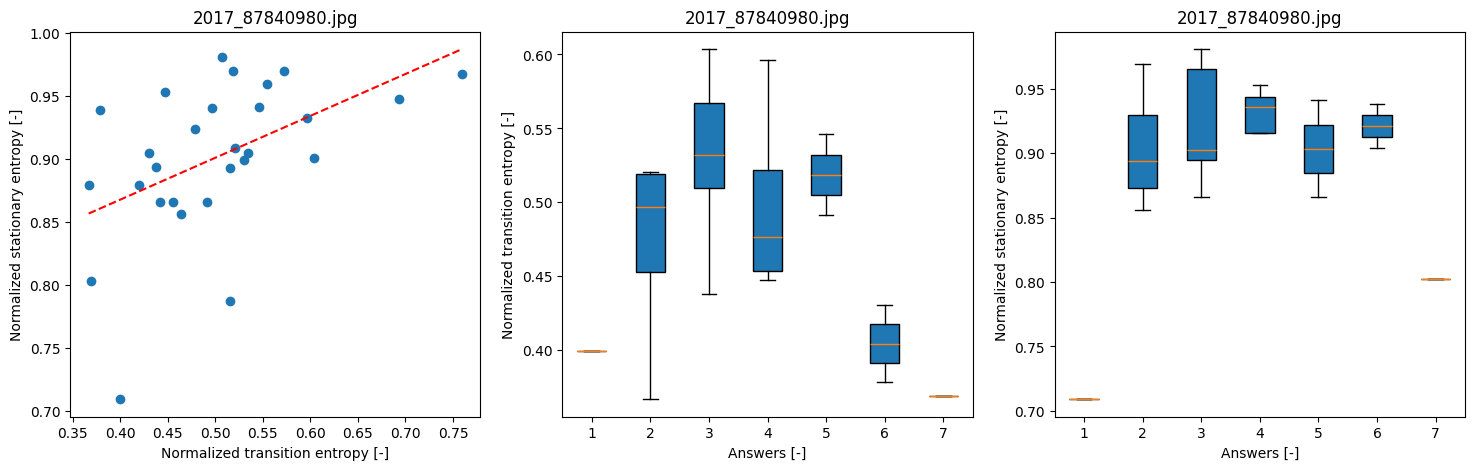

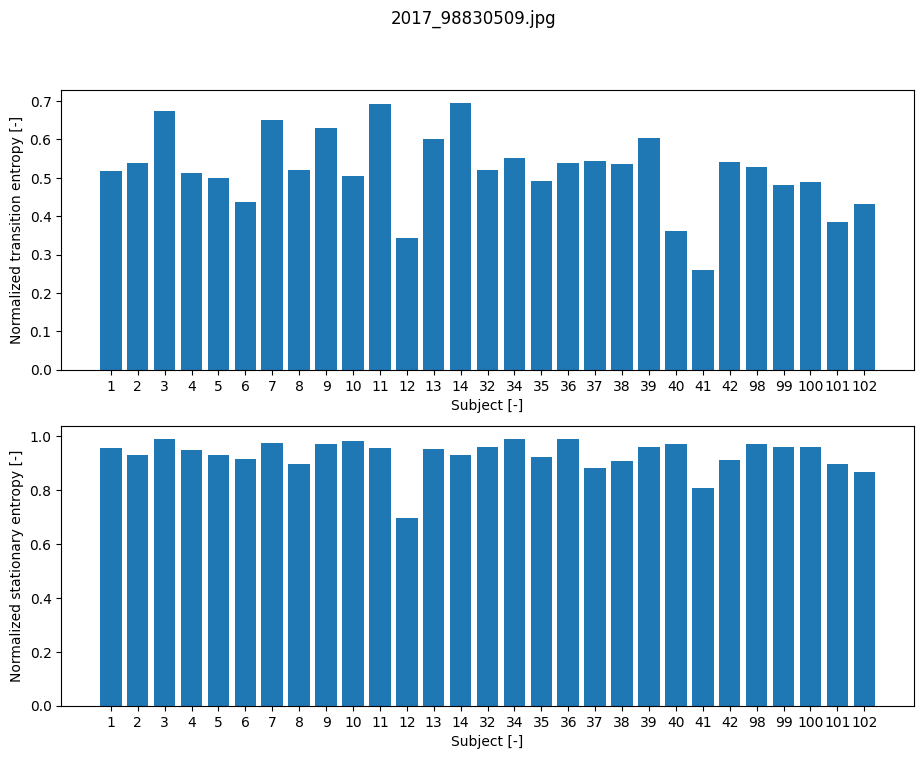

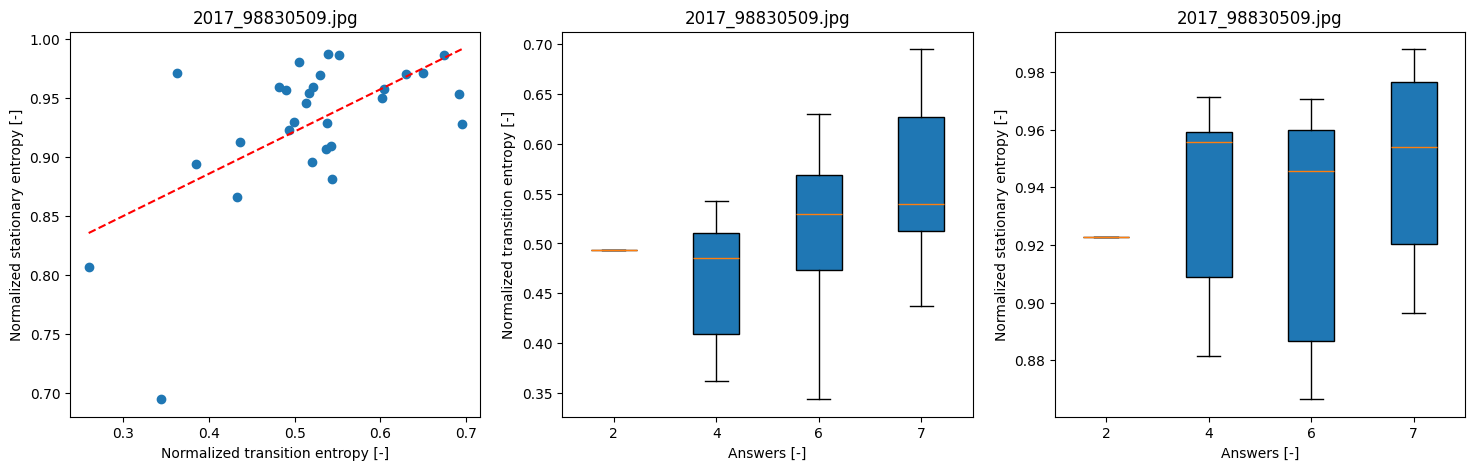

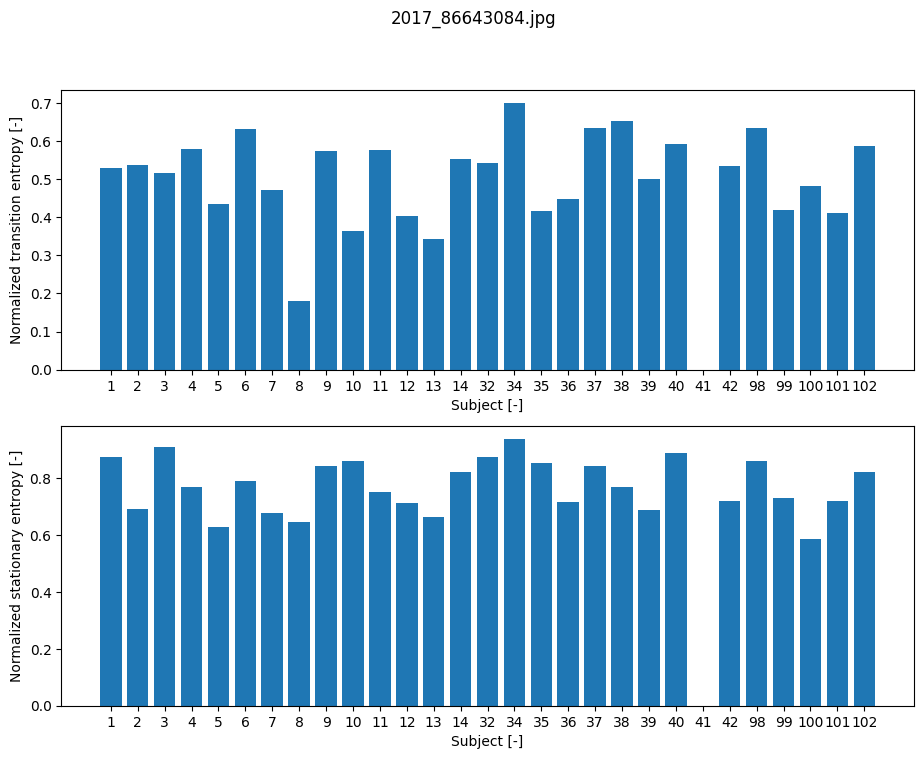

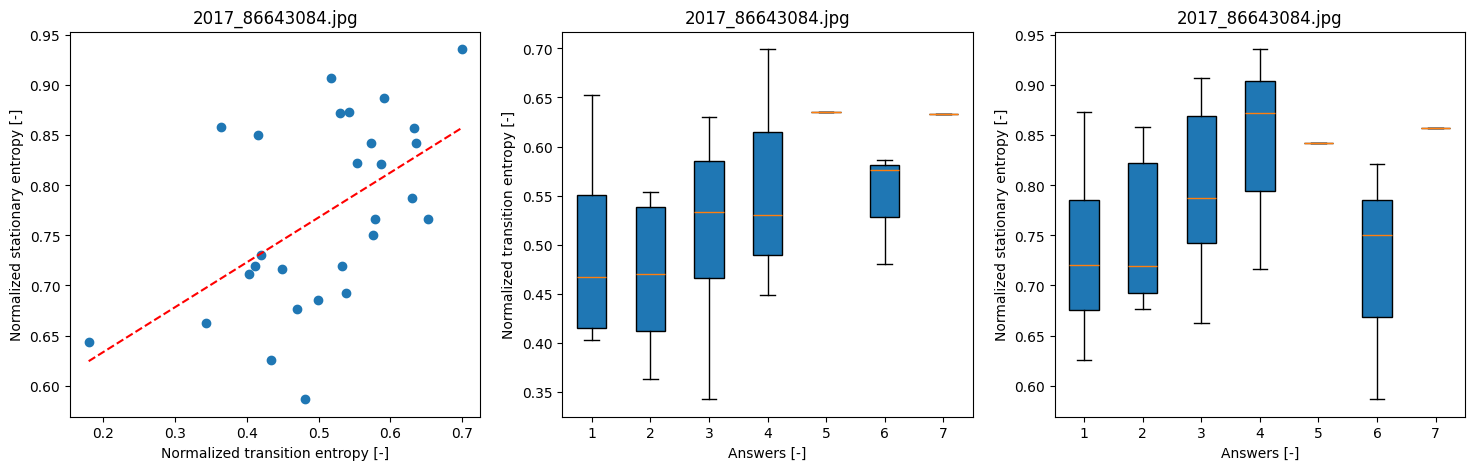

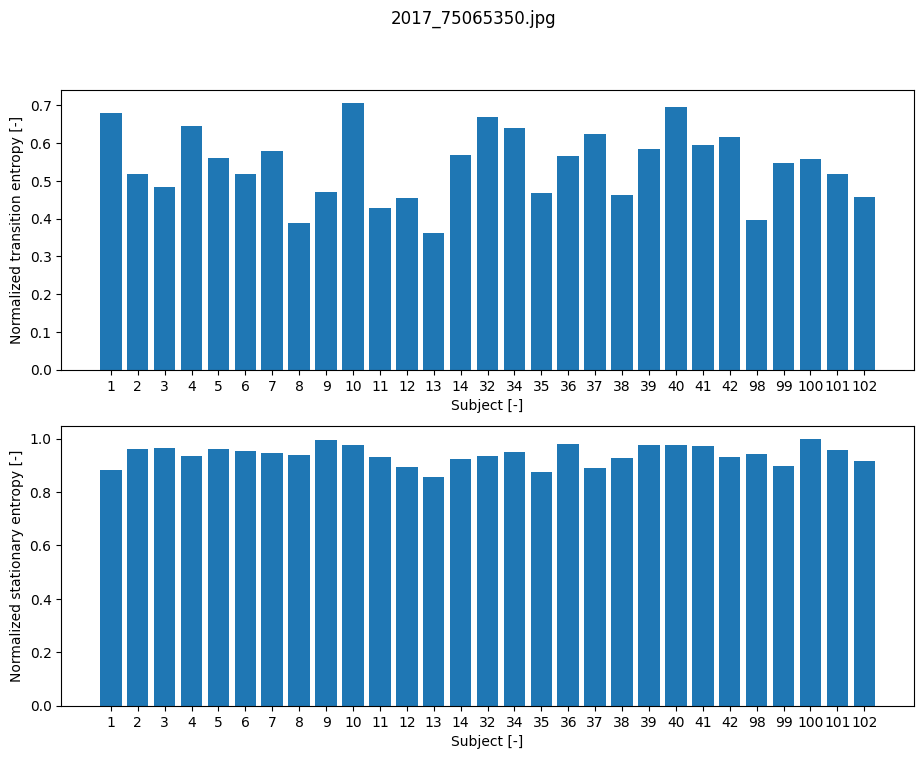

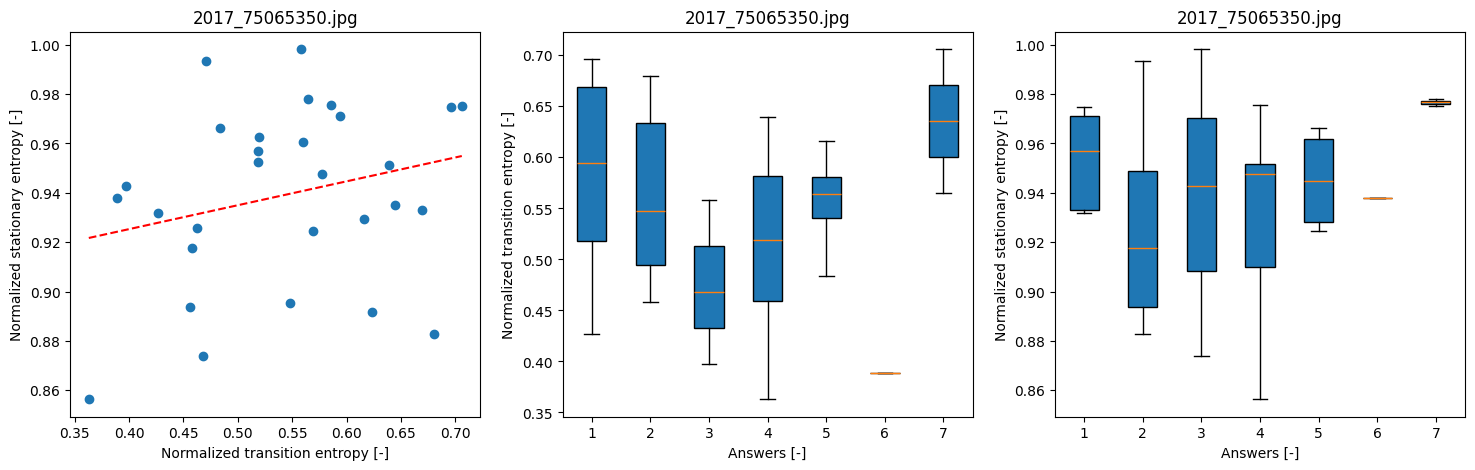

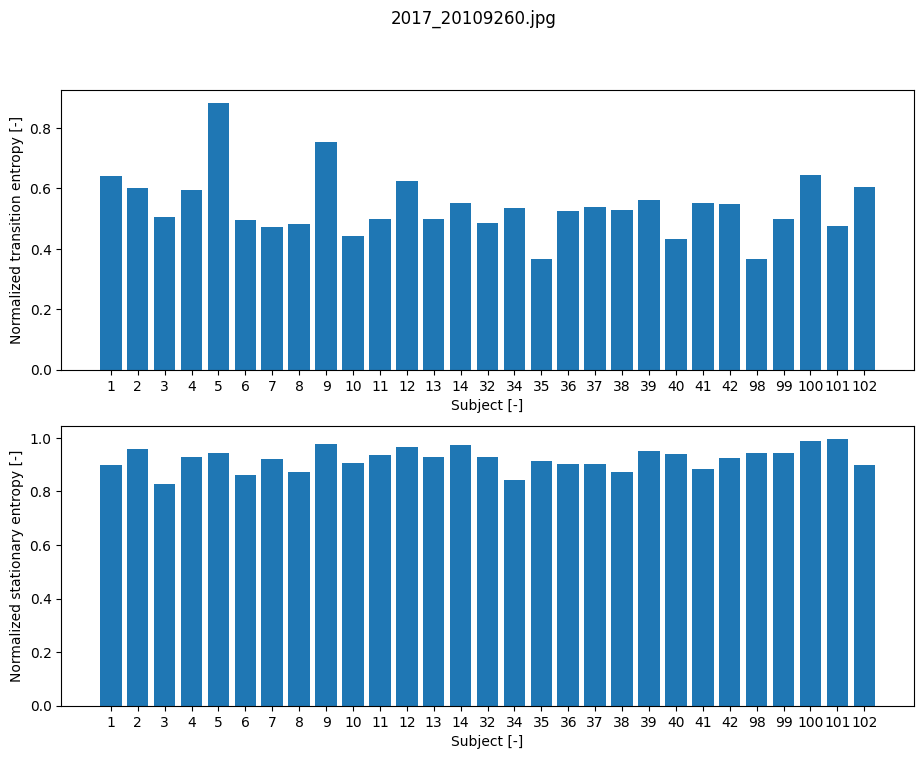

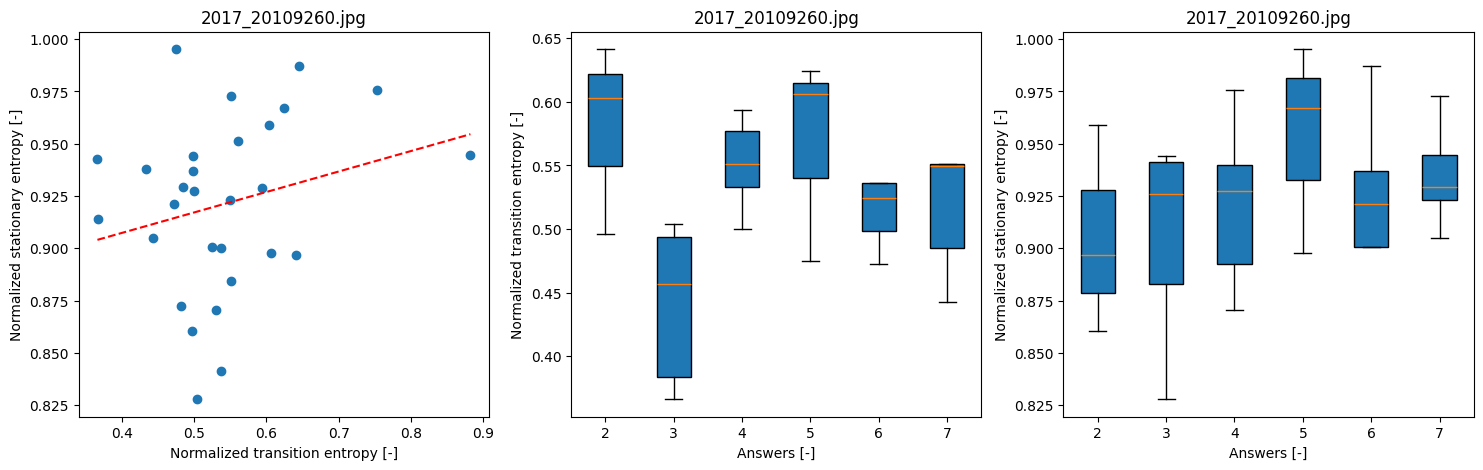

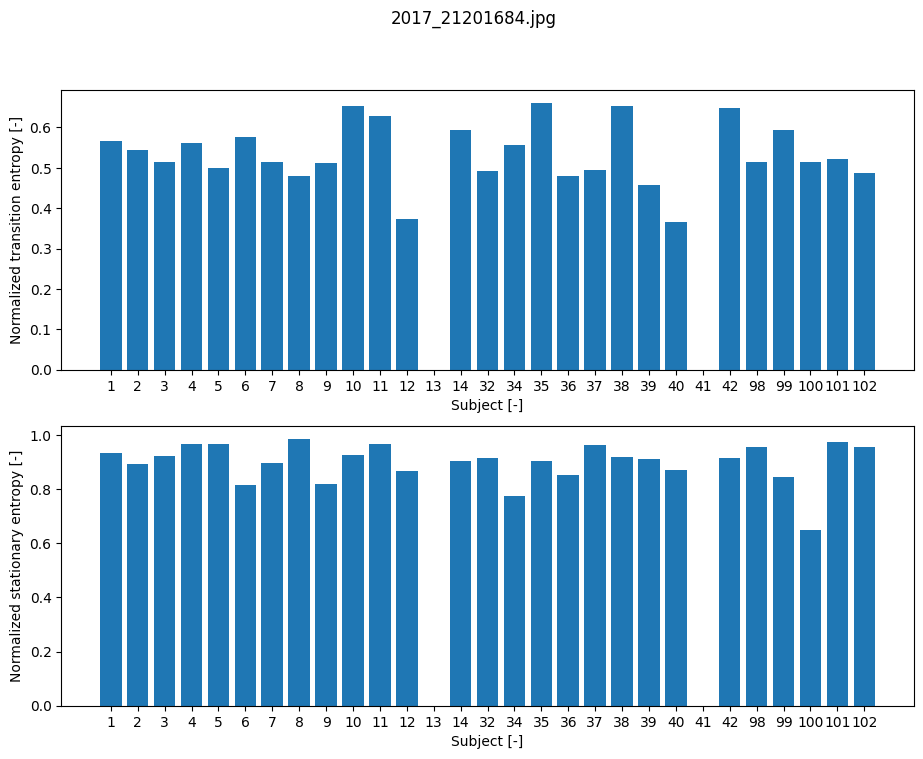

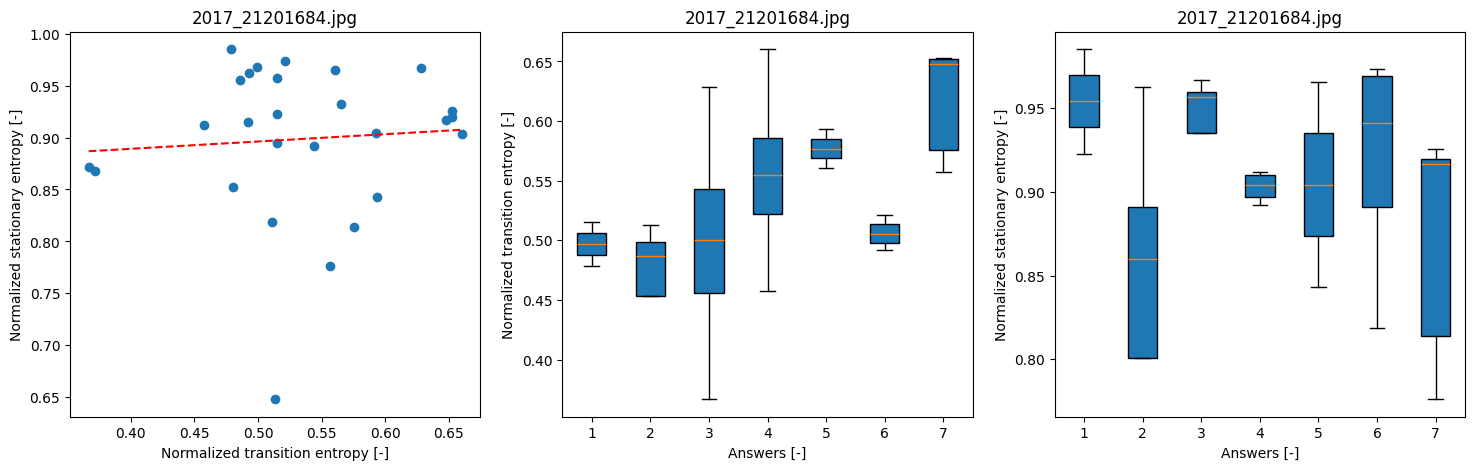

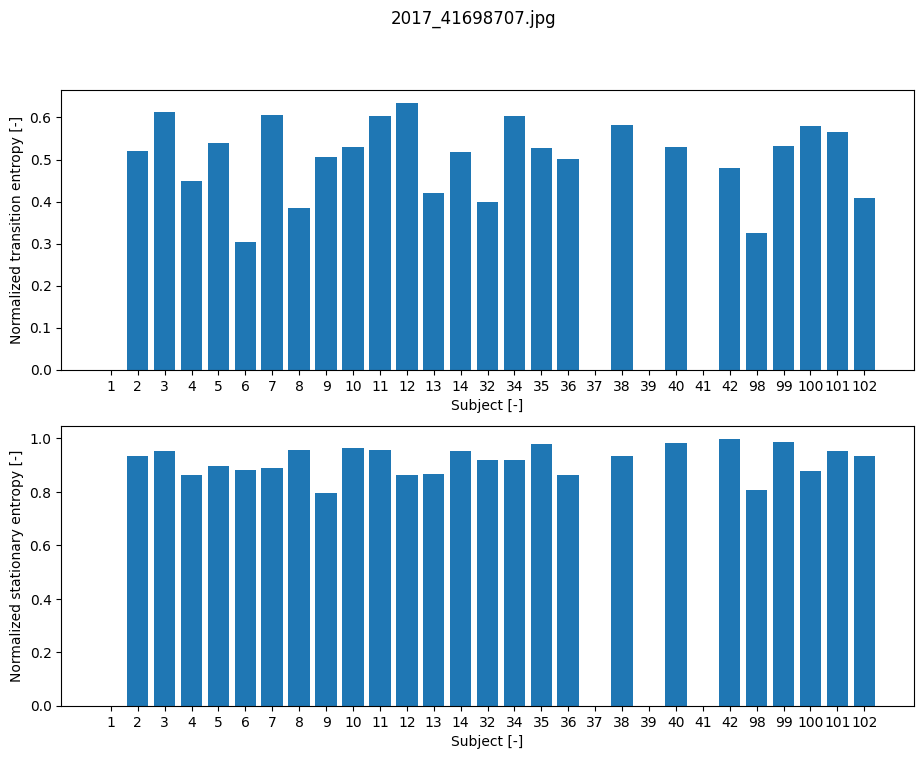

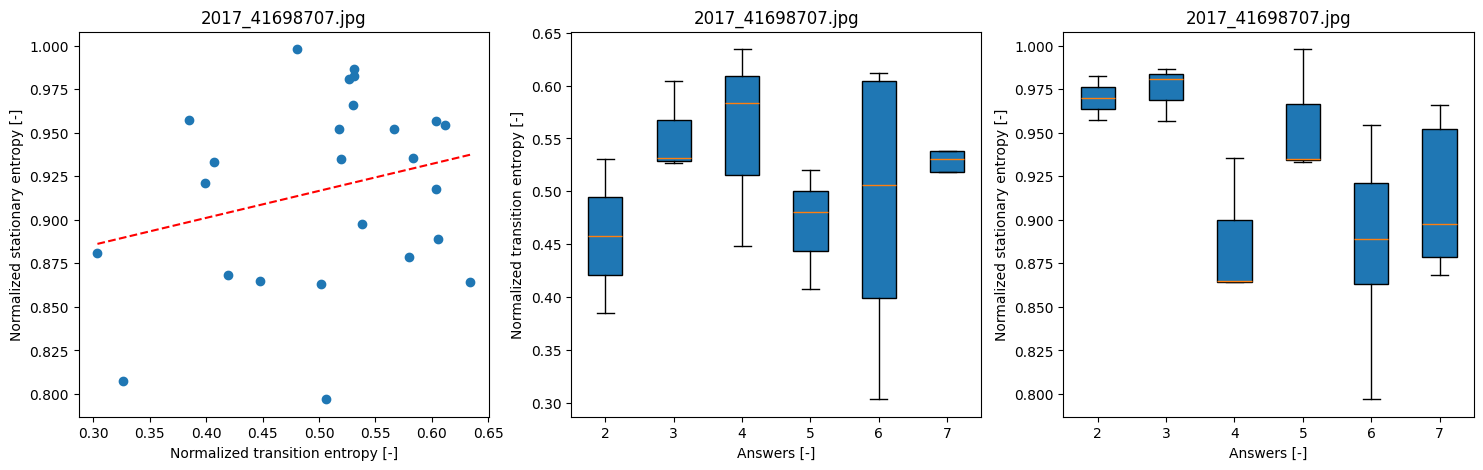

In [51]:
for img in imgs:
    img_file = dl.get_image(img)

    trials = dl.get_image_trials(img)
    answers = dl.get_image_ratings(img)

    MIN_CLUSTERS = 2
    MAX_CLUSTERS = 10

    trials_clustered: dict[int, pd.DataFrame] = {}
    cluster_centers: dict[int, dict[int, tuple[float, float]]] = {}
    for (subject, trial) in trials.items():
        df_clustered, intertia, cluster_c, k = GraphUtils.optimal_clustering(MIN_CLUSTERS, MAX_CLUSTERS, trial)
        trials_clustered[subject] = df_clustered
        cluster_centers[subject] = cluster_c

    
    matrices = {subject: GraphUtils.transition_matrix(trial, aois=cluster_centers[subject], normalize=True) for (subject, trial) in trials_clustered.items()}

    H_t = {subject: GraphUtils.transition_entropy(m) for (subject, m) in matrices.items()}

    H_s = {subject: GraphUtils.stationairy_entropy(m) for (subject, m) in matrices.items()}
    fig, axs = plt.subplots(2, 1, figsize=(11, 8))

    fig.suptitle(f"{img}")
    axs[0].bar(x=[str(key) for key in H_t.keys()], height=H_t.values())
    axs[1].bar(x=[str(key) for key in H_s.keys()], height=H_s.values())
    axs[0].set(xlabel="Subject [-]", ylabel="Normalized transition entropy [-]")
    axs[1].set(xlabel="Subject [-]", ylabel="Normalized stationary entropy [-]")
    # 12 only has a self transition, meaning nothing gets out of here -> 0 entopy as the stat dist is [0, 0... 1, ...]




    H_t_filtered = {k: v for k, v in H_t.items() if v != 0}
    H_s_filtered = {k: v for k, v in H_s.items() if v != 0}
    
    slope, intercept, r_value, p_value, std_err = linregress(np.array(list(H_t_filtered.values())), np.array(list(H_s_filtered.values())))
    x_fit = np.linspace(min(H_t_filtered.values()), max(H_t_filtered.values()), 100)
    y_fit = slope * x_fit + intercept

    fig, axs= PlotUtils.wrap_subplots(3, 3)
    axs[0].scatter(H_t_filtered.values(), H_s_filtered.values())
    axs[0].plot(x_fit, y_fit, "r--")
    axs[0].text(0.05, 0.95, 
         f"$R^2 = {r_value**2:.3f}$\n"
         f"A = {slope:.2f}, B = {intercept:.2f}",
         transform=plt.gca().transAxes,
         va="top", ha="left", fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    
    axs[0].set(xlabel="Normalized transition entropy [-]", ylabel="Normalized stationary entropy [-]", title=f"{img}")


    answers_filtered = {k: v for k, v in answers.items() if (H_t[k] !=0 and H_s[k] != 0)}

    H_t_by_answer = defaultdict(list)
    for subj in answers_filtered:
        answer = answers_filtered[subj]
        H_t_by_answer[answer].append(H_t_filtered[subj])
    H_t_by_answer_sorted = sorted(H_t_by_answer.keys())
    data_for_plot = [H_t_by_answer[label] for label in H_t_by_answer_sorted]
    axs[1].set(ylabel="Normalized transition entropy [-]", xlabel="Answers [-]", title=f"{img}")
    axs[1].boxplot(data_for_plot, tick_labels=H_t_by_answer_sorted, patch_artist=True, showfliers=False)


    H_s_by_answer = defaultdict(list)
    for subj in answers_filtered:
        answer = answers_filtered[subj]
        H_s_by_answer[answer].append(H_s_filtered[subj])
    H_s_by_answer_sorted = sorted(H_s_by_answer.keys())
    data_for_plot = [H_s_by_answer[label] for label in H_s_by_answer_sorted]
    axs[2].set(ylabel="Normalized stationary entropy [-]", xlabel="Answers [-]", title=f"{img}")
    axs[2].boxplot(data_for_plot, tick_labels=H_s_by_answer_sorted, patch_artist=True, showfliers=False)